In [1]:
import neat
import os
import evogym.envs
from evogym import is_connected, has_actuator, get_full_connectivity, hashable
import numpy as np
import dill
import pickle as pkl
import sys
sys.path.append('../')

from hyperneat.hyperNEAT import create_phenotype_network
from hyperneat.substrate import Substrate
from hyperneat.visualize import draw_net
from dynamic_env.traverser import DynamicObstacleTraverser
from dynamic_env.env_config import EnvConfig


import itertools as it
import time
import imageio

from matplotlib import pyplot as plt


from sgr.substrates import morph_substrate, control_substrate
from sgr.generate_robot import generate_robot, eval_robot_constraint
from sgr.evogym_sim import simulate_env
from sgr.body_speciation import CustomGenome
from copy import deepcopy
from PIL import Image

In [2]:
def get_robot(genome, robot_size, neat_config, env_config):
    if genome.robot is not None:
        robot = genome.robot
    else:
        cppn = neat.nn.FeedForwardNetwork.create(genome, neat_config)
        design_substrate = morph_substrate(robot_size, poet_pop.run_params.substrate_type)
        design_net = create_phenotype_network(cppn, design_substrate)
        robot = generate_robot(design_net, robot_size)
        print(robot)

    if not eval_robot_constraint(robot):
        return robot, None
    connections = get_full_connectivity(robot)

    
    env = DynamicObstacleTraverser(body=robot, connections=connections, env_config=env_config)
    img = env.render(mode='img')
    env.close()
    return robot, img

In [29]:
with open(f"../checkpoints/new_3d_2/cp_200.pkl", "rb") as file:
    poet_pop = pkl.load(file)
    
CustomGenome.robot_func = lambda self, net, config: generate_robot(net, poet_pop.run_params.robot_size)
CustomGenome.substrate = morph_substrate(poet_pop.run_params.robot_size, poet_pop.run_params.substrate_type)
CustomGenome.robot_size = poet_pop.run_params.robot_size
CustomGenome.spec_genotype_weight = poet_pop.run_params.spec_genotype_weight
CustomGenome.spec_phenotype_weight = poet_pop.run_params.spec_phenotype_weight

In [30]:
def show_img(ag, min_fit, robot_size, neat_config, env_config):
    if ag.fitness is not None and ag.fitness > min_fit:
        r, img = get_robot(ag, robot_size, neat_config, env_config)
        if img is not None:
            print(ag.key, ag.fitness)
            # print(ag.robot)
            aux = Image.fromarray(img, 'RGB')
            print(aux.size)
            display(aux.resize((aux.size[0]//3, aux.size[1]//3)))
            cppn = neat.nn.FeedForwardNetwork.create(ag, neat_config)
            
            design_substrate = morph_substrate(robot_size, poet_pop.run_params.substrate_type)
            controller_substrate = control_substrate(robot_size, "dynamic", ag.robot, poet_pop.run_params.substrate_type)

            
            design_net = create_phenotype_network(cppn, design_substrate, output_node_idx=0)
            controller_net = create_phenotype_network(cppn, controller_substrate, output_node_idx=1)

            # print("CPPN")
            # display(draw_net(cppn))
            # print("Controller:")
            # display(draw_net(controller_net))
            # print("Morphology:")
            # display(draw_net(design_net))


13


###################### Pair (env: 0, pop: 20) ########################

------------- Champion ----------------
8751 7.462083463552908
(1200, 600)


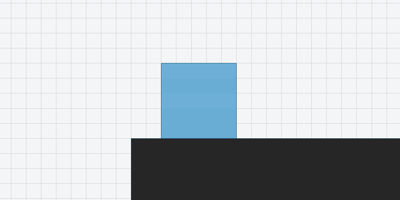



###################### Pair (env: 3, pop: 20) ########################

------------- Champion ----------------
8913 7.530073359126235
(1200, 600)


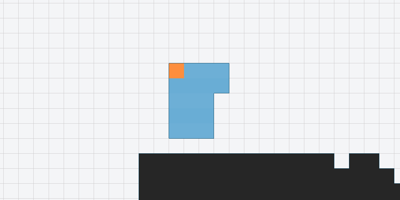



###################### Pair (env: 2, pop: 20) ########################

------------- Champion ----------------
6476 7.444637098561171
(1200, 600)


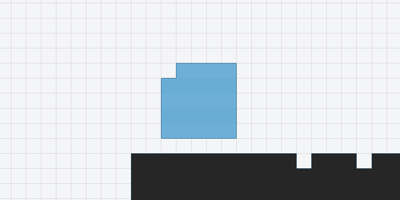



###################### Pair (env: 20, pop: 73) ########################

------------- Champion ----------------
707 7.461415273341252
(1200, 600)


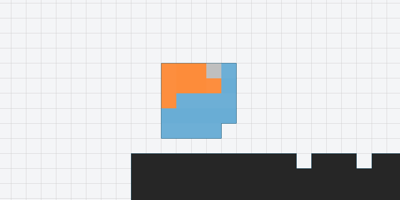



###################### Pair (env: 25, pop: 78) ########################

------------- Champion ----------------
1170 4.464193299981766
(1200, 600)


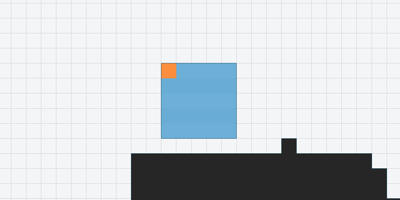



###################### Pair (env: 34, pop: 20) ########################

------------- Champion ----------------
8820 4.0362969946487794
(1200, 600)


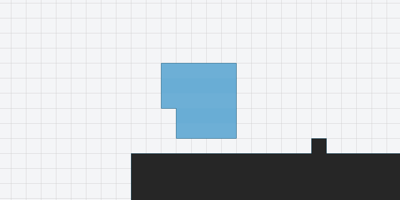



###################### Pair (env: 23, pop: 73) ########################

------------- Champion ----------------
707 3.9476115752057086
(1200, 600)


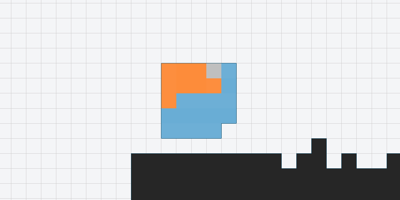



###################### Pair (env: 51, pop: 20) ########################

------------- Champion ----------------
8984 7.532502589969427
(1200, 600)


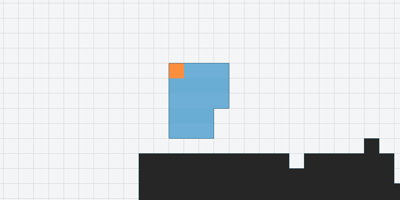



###################### Pair (env: 43, pop: 20) ########################

------------- Champion ----------------
6476 4.866537278489849
(1200, 600)


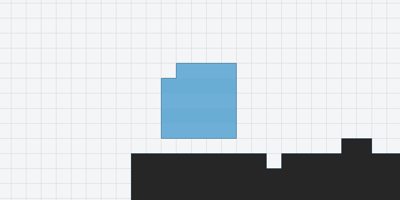



###################### Pair (env: 53, pop: 73) ########################

------------- Champion ----------------
707 7.469285364365275
(1200, 600)


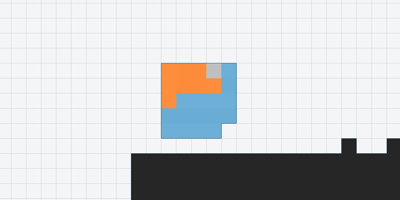



###################### Pair (env: 77, pop: 20) ########################

------------- Champion ----------------
9040 7.50883019415224
(1200, 600)


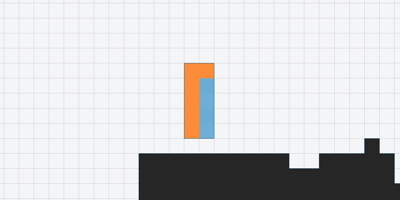



###################### Pair (env: 73, pop: 20) ########################

------------- Champion ----------------
6476 7.442898105367696
(1200, 600)


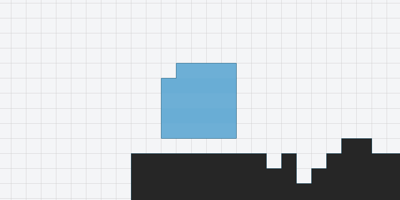



###################### Pair (env: 78, pop: 20) ########################

------------- Champion ----------------
8831 7.4761775796942045
(1200, 600)


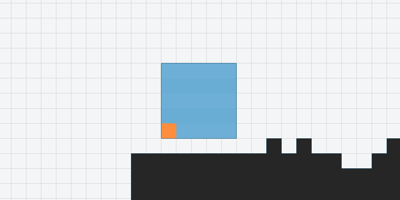

In [31]:
print(len(poet_pop.pairs))
for p in poet_pop.pairs:
    pop = p.agent_pop
    env = p.environment
    print(f"\n\n###################### Pair (env: {env.id}, pop: {pop.id}) ########################\n")
    
    # for ag_id, ag in pop.pop.population.items():
    #     show_img(ag, 4, pop.robot_size, pop.neat_config, env)
    
    print("------------- Champion ----------------")
    show_img(pop.pop.best_genome, -1, pop.robot_size, pop.neat_config, env)


In [32]:
STEPS = 600
env_dict = {}
ag_dict = {}
for p in poet_pop.pairs:
    pop = p.agent_pop
    env = p.environment
    for ag_id, ag in pop.pop.population.items():
        ag_dict[ag_id] = (ag, pop)
    env_dict[env.id] = env



In [33]:
def show_exec(ag_id, env_id):
    ag, pop = ag_dict[ag_id]
    env0 = EnvConfig(0)
    env1 = env0.create_child()
    env1.mutate_barrier_h(.25)
    env2 = env0.create_child()
    env2.mutate_barrier_h(.25)
    env3 = env1.create_child()
    env3.mutate_barrier_h(.25)
    env4 = env1.create_child()
    env4.mutate_barrier_h(.25)
    env5 = env2.create_child()
    env5.mutate_barrier_h(.25)
    env6 = env2.create_child()
    env6.mutate_barrier_h(.25)
    print(ag.robot)
    reward, done = pop.single_genome_fit(ag, STEPS, "dynamic", env4, True, None)
    return reward, done

In [34]:
r, d = show_exec(8984, 0)
print(r)

[[3 4 4 4 0]
 [4 4 4 4 0]
 [4 4 4 4 0]
 [4 4 4 0 0]
 [4 4 4 0 0]]
4.383473799505808


In [18]:
env0 = EnvConfig(0)
env1 = env0.create_child()
env1.mutate_barrier_h(.25)
env2 = env0.create_child()
env2.mutate_barrier_h(.25)
env3 = env1.create_child()
env3.mutate_barrier_h(.25)
env4 = env1.create_child()
env4.mutate_barrier_h(.25)
env5 = env2.create_child()
env5.mutate_barrier_h(.25)
env6 = env2.create_child()
env6.mutate_barrier_h(.25)

In [20]:
ag, pop = ag_dict[1653]
pop.single_genome_fit(ag, STEPS, "dynamic", env6, True, None)

(-4.617183477186651, False)